In [2]:
%matplotlib inline
from re import DEBUG
from turtle import color
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from warnings import simplefilter
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import WindowsPath
import time
from collections import defaultdict


In [22]:

dev_df = pd.read_csv(
    "development.csv", header=0, index_col=False
)
dev_df.head()

,x,y,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,200.0,200.0,4.066907,-17.690173,2.847932,0.600000,2.007042,5.409161,-17.721210,4.538778,...,607.109118,-36.282996,583.899899,72.373094,0.374498,614.916861,-39.848523,591.852768,72.331028,0.405595
1,200.0,200.0,5.916801,-4.717111,5.792778,79.765174,1.564535,4.414289,-4.736827,3.720435,...,630.348007,-39.715988,580.042799,71.029155,0.403258,624.950701,-41.266681,586.569646,71.089058,0.405890
2,200.0,200.0,4.286652,-5.316132,2.356390,74.600000,1.404622,4.567191,-5.985437,3.490490,...,613.880342,-40.679678,580.407491,71.892264,0.568777,596.437125,-42.712286,574.091695,71.943934,0.498019
3,200.0,200.0,4.003635,-4.617459,2.189005,43.000000,1.512162,5.019058,-4.229949,6.786200,...,600.714957,-43.206601,579.882635,72.357388,0.255483,591.763739,-50.681940,584.099483,72.333282,0.336454
4,200.0,200.0,4.448146,-4.848743,3.997002,196.667482,1.101113,3.250262,-5.783587,2.449456,...,609.723785,-43.570892,590.156125,71.249130,0.413855,606.917023,-49.923819,584.316142,71.242904,0.293824


c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='negpmax[14]', ylabel='Proportion'>

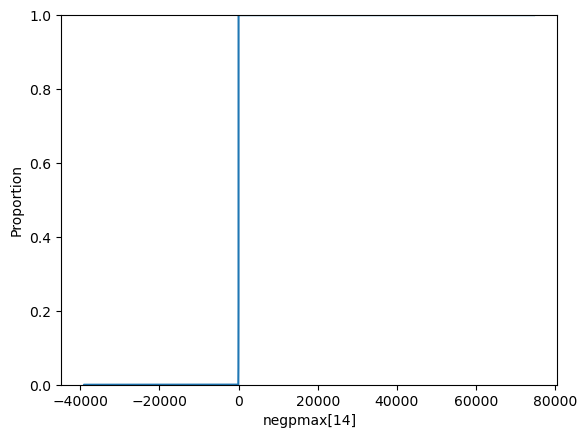

In [23]:
name_cols: list[str] = []
prefix = "pmax"
for i in range(18):
    name_cols.append(f"{prefix}[{i}]")

# dfm = dev_df.melt(
#     id_vars=["x", "y"],
#     var_name=f"{prefix}",
#     value_name="values",
#     value_vars=name_cols,
# )
# sns.ecdfplot(dfm, y="prefix", x="values", color=sns.color_palette()[0])

sns.ecdfplot(dev_df, x="negpmax[14]", color=sns.color_palette()[0])



c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


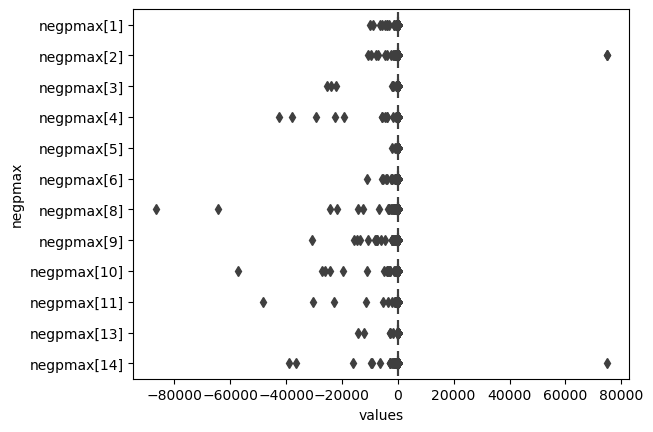

In [35]:
print()
prefix = "negpmax"
name_cols: list[str] = []
for i in [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14]:
    name_cols.append(f"{prefix}[{i}]")

dfm = dev_df.melt(
    id_vars=["x", "y"],
    var_name=f"{prefix}",
    value_name="values",
    value_vars=name_cols,
)
plot = sns.boxplot(dfm, y=f"{prefix}", x="values", color=sns.color_palette()[0])
# plt.gca().set(xlim=(-100, 0))

c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='negpmax[8]', ylabel='Count'>

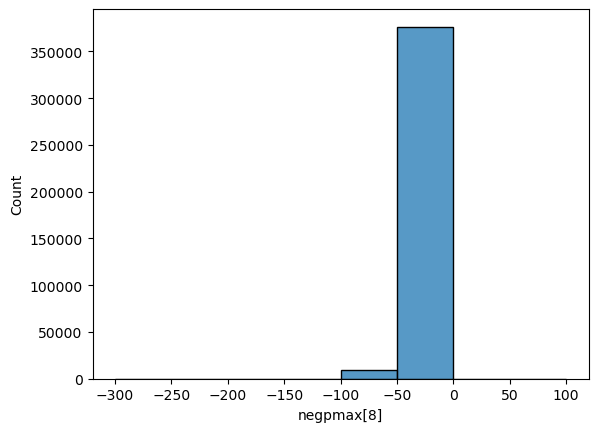

In [40]:
sns.histplot(dev_df, x="negpmax[8]", bins = [-300, -200, -150, -100, -50, 0, 100])

0.008041504539559013


c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='negpmax[8]', ylabel='Proportion'>

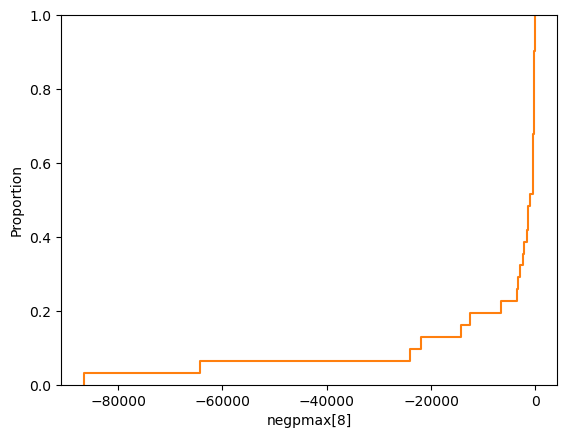

In [50]:

mask = (dev_df["negpmax[8]"]<-100) |  (dev_df["negpmax[8]"]>100)
print(mask.sum()/dev_df.shape[0]*100)
# sns.histplot(dev_df[mask], x="negpmax[8]", bins = [-90000, -300, -200, -150, -100])
sns.ecdfplot(dev_df[mask], x="negpmax[8]", color=sns.color_palette()[1])

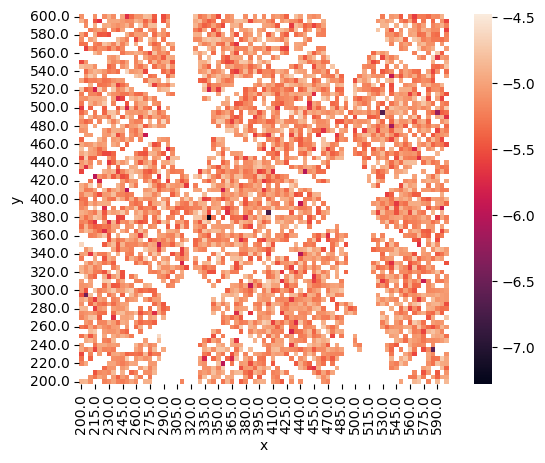

In [34]:
col = 15
name_col = f"negpmax[{col}]"
df_plot = dev_df[["x", "y", name_col]]
mask = (df_plot[name_col]>=-300) & (df_plot[name_col]<=0)
df_plot = df_plot.loc[mask, :]
data_heatmap = (
    df_plot.groupby(["x", "y"])
    .mean()
    .reset_index()
    .sort_values(by=["x", "y"], ascending=[True, False])
    .pivot(index="y", columns="x", values=name_col)
    .sort_index(ascending=False)
)
fig, ax = plt.subplots(1, 1)
plot = sns.heatmap(
    data_heatmap,
    ax=ax,
    square=True,
    cbar_kws={"location": "right"},
)